# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

solidYellowCurve.jpg
solidYellowLeft.jpg
solidYellowCurve2.jpg
solidWhiteRight.jpg
whiteCarLaneSwitch.jpg
solidWhiteCurve.jpg


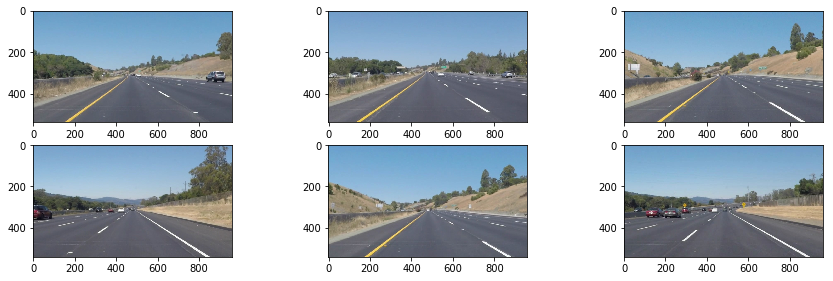

In [3]:
# Show preview of all test images
fig = plt.figure(figsize=(15, 7))
test_images = os.listdir("test_images/")
for file in test_images:
    print(file)
for idx, img_path in enumerate(test_images):
    image = mpimg.imread('test_images/' + img_path)
    fig.add_subplot(len(test_images)/2, 3, idx+1)
    plt.imshow(image)

plt.show()


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [8]:
# paint yellow lanes white
def highlight_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    yellow_mask = cv2.inRange(hsv, np.array([90,100,100]), np.array([110,255,255]))
    
    indices = np.where(yellow_mask==255)
    img_copy = img.copy()
    img_copy[indices[0], indices[1], :] = [255, 255, 255]
    return img_copy

# helpers
def get_img_height_width(img):
    img_shape = img.shape
    return img_shape[0], img_shape[1]

def get_intersection(slope1, intercept1, slope2, intercept2):
    intersection_x = (intercept2 - intercept1)/(slope1 - slope2)
    intersection_y = intersection_x * slope1 + intercept1
    return intersection_x, intersection_y

def crop_to_roi(img):
    img_height, img_width = get_img_height_width(img)
    vertices = np.array([[(20,img_height),
                          ((5/11)*img_width,(1/2)*img_height),
                          ((6/11)*img_width,(1/2)*img_height),
                          (img_width-20,img_height)]],
                          dtype=np.int32)
    return region_of_interest(img, vertices)

def get_slope(line):
    for x1,y1,x2,y2 in line:
        return (y2-y1)/(x2-x1)


def get_intercept(line):
    slope = get_slope(line)
    for x1,y1,x2,y2 in line:
        return y1 - slope * x1

def get_avg(data):
    if len(data) == 0:
        return -1
    return sum(data) / len(data)

# helper func for extrapolating two lanes
def extrapolate_lanes(img, lines):
    img_height, img_width = get_img_height_width(img)

    slopes = list(map(lambda line: get_slope(line), lines))
    intercepts = list(map(lambda line: get_intercept(line), lines))

    # group data by slope
    slopes_cp = slopes.copy()
    slopes_cp, intercepts = (list(t) for t in zip(*sorted(zip(slopes_cp, intercepts), key=lambda tup: tup[0])))
    slopes, lines = (list(t) for t in zip(*sorted(zip(slopes, lines), key=lambda tup: tup[0])))

    num_gaps = 0    

    for s in range(len(slopes) - 1):
        if slopes[s+1] - slopes[s] > 0.5 or abs(intercepts[s+1] - intercepts[s]) > 100:
            num_gaps = num_gaps + 1
    
    freq, bins = np.histogram(slopes, num_gaps+1)

    # group detected lines by slopes and intercepts
    bins_slopes = []
    bins_lines = []
    bins_intercepts = []
    bin_start = 0
    for bin_count in range(len(freq)):
        if freq[bin_count] == 0:
            continue
        bins_slopes.append(slopes[bin_start:bin_start+freq[bin_count]])
        bins_lines.append(lines[bin_start:bin_start+freq[bin_count]])
        bins_intercepts.append(intercepts[bin_start:bin_start+freq[bin_count]])
        bin_start = bin_start + freq[bin_count]
    
    avg_slopes = list(map(lambda x: get_avg(x), bins_slopes))
    avg_intercepts = list(map(lambda x: get_avg(x), bins_intercepts))

    # tend to cases where more or less than two lanes were identified
    if len(avg_slopes) > 2:
        left_id = -1
        left_intercept = -100000
        right_id = -1
        right_intercept = 100000
        for i in range(len(avg_slopes)):
            if avg_slopes[i] < 0 and avg_intercepts[i] > left_intercept:
                left_id = i
                left_intercept = avg_intercepts[i]
            if avg_slopes[i] > 0 and avg_intercepts[i] < right_intercept:
                right_id = i
                right_intercept = avg_intercepts[i]
        if left_id != -1 and right_id != -1:
            avg_slopes = list((avg_slopes[left_id],avg_slopes[right_id]))
            avg_intercepts = list((avg_intercepts[left_id],avg_intercepts[right_id]))
        elif left_id != -1:
            avg_slopes = avg_slopes[left_id:left_id+1]
            avg_intercepts = avg_intercepts[left_id:left_id+1]
        elif right_id != -1:
            avg_slopes = avg_slopes[right_id:right_id+1]
            avg_intercepts = avg_intercepts[right_id:right_id+1]

    if len(avg_slopes) < 2:
        intersection_x, intersection_y = int(img_width/2), int(img_height/2)
    else:
        intersection_x, intersection_y = get_intersection(avg_slopes[0], avg_intercepts[0], avg_slopes[1], avg_intercepts[1])

    # draw lane lines
    extra_lines = []
    for lane in range(0,len(avg_slopes)):
        x1 = (intersection_y + 10 - avg_intercepts[lane]) / avg_slopes[lane]
        x2 = (img_height - avg_intercepts[lane]) / avg_slopes[lane]
        
        if x1 == float("inf") or x2 == float("inf"):
            continue
        if avg_slopes[lane] == -1 or avg_intercepts[lane] == -1:
            continue

        extra_lines.append([int(x1),
                            int(intersection_y + 10),
                            int(x2),
                            img_height])
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, np.array([extra_lines]), [255, 0, 0], 5)

    return line_img

# main process to do lane detection
def find_lanes(img):
    img_yellow = highlight_yellow(img)
    
    img_gray = grayscale(img_yellow)

    img_gaussian = gaussian_blur(img_gray, 7)

    img_canny = canny(img_gaussian, 200, 240)

    img_cropped = crop_to_roi(img_canny)

    lines = cv2.HoughLinesP(img_cropped, 2, np.pi/180, 50, np.array([]), 10, 20)

    extrapolated_lines = extrapolate_lanes(img_cropped, lines)

    img_weighted = weighted_img(extrapolated_lines, img)

    return img_weighted


# # only for direct testing
# img = find_lanes(mpimg.imread('test_images/solidYellowLeft.jpg'))
# plt.imshow(img)



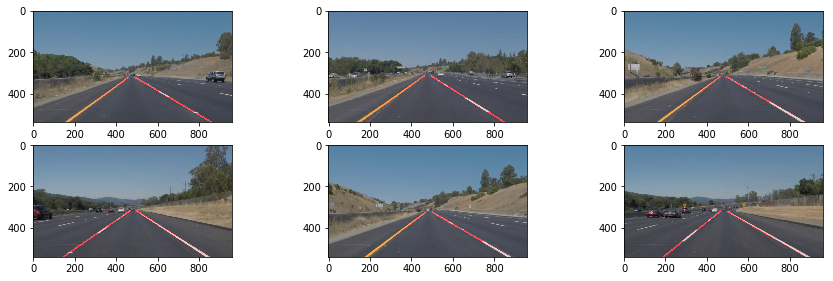

In [9]:
# Detect lanes on all test images
fig = plt.figure(figsize=(15, 7))
test_images = os.listdir("test_images/")
if not os.path.exists("test_images_output/"):
    os.makedirs("test_images_output/")

for idx, img_path in enumerate(test_images):
    image = find_lanes(mpimg.imread('test_images/' + img_path))
    fig.add_subplot(len(test_images)/2, 3, idx+1)
    cv2.imwrite('test_images_output/' + img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.imshow(image)

plt.show()

## Videos 🎥

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return find_lanes(image)

In [11]:
# Process all test videos 

test_videos = os.listdir("test_videos/")

for video in test_videos:
    output = 'test_videos_output/' + video
    clip = VideoFileClip("test_videos/" + video)
    processed_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:07<00:00, 17.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.44 s, sys: 459 ms, total: 5.9 s
Wall time: 8.98 s
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:17<00:00, 18.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.5 s, sys: 1.46 s, total: 12 s
Wall time: 19.3 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 79%|███████▉  | 539/682 [00:19<00:08, 17.16it/s]


100%|█████████▉| 681/682 [00:25<00:00, 26.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.4 s, sys: 1.96 s, total: 18.4 s
Wall time: 26 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
# Watch all videos

test_videos = list(filter(lambda x: x.find(".mp4") >= 0, os.listdir("test_videos_output/")))
html_string = ""

for video in test_videos:
    html_string = html_string + """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/"+video)

HTML(html_string)

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


In [13]:
if not os.path.exists("writeup_images/"):
    os.makedirs("writeup_images/")

img_path = 'test_images/solidYellowLeft.jpg'

img = mpimg.imread(img_path)

img_yellow = highlight_yellow(img)
cv2.imwrite('writeup_images/img_yellow.jpg', cv2.cvtColor(img_yellow, cv2.COLOR_RGB2BGR))

img_gray = grayscale(img_yellow)
cv2.imwrite('writeup_images/img_gray.jpg',img_gray)

img_gaussian = gaussian_blur(img_gray, 7)
cv2.imwrite('writeup_images/img_gaussian.jpg',img_gaussian)

img_canny = canny(img_gaussian, 180, 200)
cv2.imwrite('writeup_images/img_canny.jpg',img_canny)

img_cropped = crop_to_roi(img_canny)
cv2.imwrite('writeup_images/img_cropped.jpg',img_cropped)

lines = cv2.HoughLinesP(img_cropped, 2, np.pi/180, 50, np.array([]), 10, 20)
img_lines = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines(img_lines, lines)
cv2.imwrite('writeup_images/img_lines.jpg',img_lines)

extrapolated_lines = extrapolate_lanes(img_cropped, lines)
img_weighted = weighted_img(extrapolated_lines, img)
cv2.imwrite('writeup_images/img_weighted.jpg',cv2.cvtColor(img_weighted, cv2.COLOR_RGB2BGR))



True